# Data Preprocessing

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
# from time import strptime
import datetime
import time

import dataloader as dl

from IPython.display import display
from ipywidgets import FloatProgress
from metpy.plots import SkewT


%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
vol = '/Users/stock/Development/research/soundings/data/subset/'

In [3]:
fin = vol + '/radiosonde/20190912.dat'
radiosondes = dl.read_sonde(fin)

interval = 5

Y = []
X = []

for i in range(len(radiosondes)):
    
    ## extract SOUNDINGS
    y = []
    sonde = pd.DataFrame(radiosondes[i]['data']).values
    
    # interpolate sounding values 
    for j in range(len(sonde) - 1):
        # pressure, temperature, dewpoint
        p1, t1, td1 = sonde[j][1], sonde[j][3], sonde[j][4]
        p2, t2, td2 = sonde[j+1][1], sonde[j+1][3], sonde[j+1][4]
        # temperature slope
        mt = (t1-t2)/(p1-p2)
        bt = -mt*p1 + t1
        # dewpoint slope
        mtd = (td1-td2)/(p1-p2)
        btd = -mtd*p1 + td1
        # add new values within interval
        for p in np.arange(p1, p2, -1):
            if p % interval == 0:
                t = mt*p + bt
                td = mtd*p + btd
                y.append([p, t, td])
                
    Y.append(np.array(y))
    
    sonde_meta = radiosondes[i]['metadata']
    date = datetime.datetime(int(sonde_meta['YEAR']), time.strptime(sonde_meta['MONTH'],'%b').tm_mon, 
                             int(sonde_meta['DAY']), int(sonde_meta['HOUR']), tzinfo=datetime.timezone.utc)
    lat, lon = sonde_meta['LAT'], sonde_meta['LON']
    print(date, lat, lon)
    
    x = {}
    x['date'] = date
    x['lat'] = lat
    x['lon'] = lon
    
    ## extract GOES
    
    ## extract RTMA
    indicies = {'Pressure': 'P_s', 'Temperature': 'T_s', 'Dew point temperature': 'Td_s'}
    for d in glob.glob(vol + 'rtma/' + date.strftime('*%Y%m%d*/')):
        for f in glob.glob(d + '/' + date.strftime('*%Y%m%d%H%M')):
            D = dl.read_rtma(f)
            x_cord, y_cord = dl.lat_lon_point(D, lat, lon)
            try:
                x[indicies[D['name']]] = D['data'][x_cord][y_cord]
            except:
                print(f'ERROR! Unable to extract RTMA value for {f},'
                      f'{date}, {lat}, {lon}')
                
    ## extract NWP
    # TODO: extract P/T/Td values with intropolation at interval.
    #       replace the key value index in $x$, then append to X.
    X.append(x)

2020-09-12 14:00:00+00:00 32.5 -114.0
2019-09-12 16:00:00+00:00 32.5 -114.0
2019-09-12 20:00:00+00:00 32.5 -114.0
2019-09-12 19:00:00+00:00 41.6 -90.57
2019-09-12 15:00:00+00:00 28.48 -80.55


In [4]:
pd.DataFrame(X)

,date,lat,lon,P_s,T_s,Td_s
0,2020-09-12 14:00:00+00:00,32.50,-114.00,NaN,NaN,NaN
1,2019-09-12 16:00:00+00:00,32.50,-114.00,96092.0,302.14,286.30
2,2019-09-12 20:00:00+00:00,32.50,-114.00,95956.0,305.45,286.42
3,2019-09-12 19:00:00+00:00,41.60,-90.57,98918.0,304.74,295.39
4,2019-09-12 15:00:00+00:00,28.48,-80.55,101728.0,303.34,297.87


In [169]:
sonde_meta = radiosondes[1]['metadata']
date0 = datetime.datetime(int(sonde_meta['YEAR']), time.strptime(sonde_meta['MONTH'],'%b').tm_mon, 
                         int(sonde_meta['DAY']), int(sonde_meta['HOUR']), tzinfo=datetime.timezone.utc)

sonde_meta = radiosondes[2]['metadata']
date1 = datetime.datetime(int(sonde_meta['YEAR']), time.strptime(sonde_meta['MONTH'],'%b').tm_mon, 
                         int(sonde_meta['DAY']), int(sonde_meta['HOUR']), tzinfo=datetime.timezone.utc)

a = abs(date0 - date1)
b = abs(date1 - date0)

a, b

(datetime.timedelta(seconds=14400), datetime.timedelta(seconds=14400))

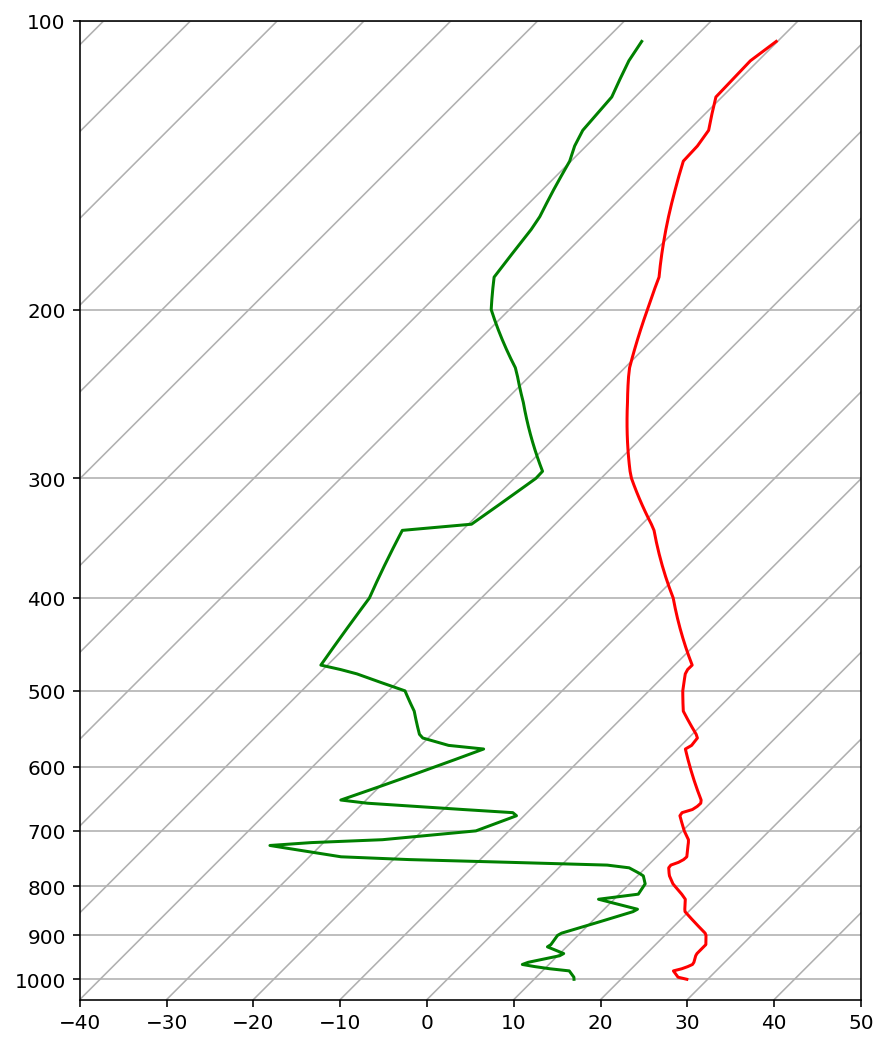

In [139]:
fig = plt.figure(figsize=(7, 9))
skew = SkewT(fig, rotation=45)
i = 1
skew.plot(Dns[i][:,0], Dns[i][:,1], 'r');
skew.plot(Dns[i][:,0], Dns[i][:,2], 'g');

$
\begin{align}
X_n  & \\
& G_8 : \text{upper-level water vapor 6.2}\mu m \\
& G_9 : \text{mid-level water vapor 6.9}\mu m \\
& G_{10} : \text{lower-level water vapor 7.3}\mu m \\
& G_{11} : \text{cloud-top phase 8.4}\mu m \\
& G_{13} : \text{clean longwave window 10.3}\mu m \\
& G_{14} : \text{longwave window 11.2}\mu m \\
& G_{15} : \text{dirty longwave window 12.3}\mu m \\
& G_{16} : \text{CO2 longwave 13.3}\mu m \\
& P^s : \text{RTMA Surface Pressure} \\
& T^s : \text{RTMA Surface Temperature} \\
& T_d^s : \text{RTMA Surface Dew Point} \\
& P^n : \text{NWP Pressure, 25 mb increments} \\
& T^n : \text{NWP Temperature} \\
& T_d^n : \text{NWP Dew Point} \\
Y_n  & \\
& T^r : \text{Radiosonde Temperature} \\
& T_d^r : \text{Radiosonde Dew Point} 
\end{align}
$

| date          | lat  | lon | $G_n$ | $P^s$ | $T^s$ | $T_d^s$ | $P^n$ | $T^n$ | $T_d^n$ | ---- | $T^r$ | $T_d^r$ |
|:-------------:| :--: |:--: | :--:  | :--:  | :--:  | :--:    | :--:  | :---: | :--:    | ---- | :--:  | :--:    |
|2019-09-12-0300| 40.2 | -95.| ...   | 999   | 32.0  | 21.5    | 1000  | 31.2  | 22.2    | ---- | 31.6  | 21.9    |
|2019-09-12-0300| 40.2 | -95.| ...   | 999   | 32.0  | 21.5    | 975   | 31.5  | 21.9    | ---- | 31.2  | 21.4    |
...


| date          | lat  | lon | $G_n$ | $P^s$ | $T^s$ | $T_d^s$ | $T_{1000}^n$ | $T_{d1000}^n$ | $T_{995}^n$ | $T_{d995}^n$ | ... | ---- | $T_{1000}^r$ | $T_{d1000}^r$ | $T_{995}^r$ | $T_{d995}^r$ | ... |
|:-------------:| :--: |:--: | :--:  | :--:  | :--:  | :--:   | :---: | :--:     | :---: | :--:    | :--:  |  ---- | :--:  | :--:    | :--:  | :--:    | :--:    |
|2019-09-12-0300| 40.2 | -95.| ...   | 999   | 32.0  | 21.5    | 31.2  | 22.2     | 31.2  | 22.2    | ... | ---- | 31.6  | 21.9    | 31.6  | 21.9    | ... |